# Quantile Multiplicative Updates for Corruption-Robust Nonnegative Matrix Factorization

*Authors:* Zane Collins, Jamie Haddock, Tyler Headley, Luke Wang

Department of Mathematics, Harvey Mudd College, Claremont, CA, USA

This notebook is the code appendix for our submission to SampTA 2025. Included are "bonus" experiments that we did not have space for in the conference submission; all figures appearing in the final submission are labeled "Figure X" in the notebook headings, corresponding to the submission.

# Data

The following code was used to generate and corrupt swimmer and synthetic data.

## Corrupt Matrix

In [15]:
import numpy as np

def corrupt_matrix(D_tilde, beta=0.1, corruption_scale=1e6):
    """
    Generates a corrupted data matrix D from an uncorrupted data matrix D_tilde.

    This function simulates corruption by adding noise to a fraction of the entries in D_tilde.
    The observed data is given by:
        D = D_tilde + C,
    where C is a sparse corruption matrix. A fraction beta of the entries in D_tilde
    are corrupted by adding noise drawn from the absolute value of a Gaussian distribution,
    i.e., |N(0, corruption_scale^2)|, ensuring nonnegative noise.

    Parameters:
        D_tilde (np.ndarray): The original, uncorrupted data matrix.
        beta (float): The fraction of entries to corrupt (0 < beta < 1).
        corruption_scale (float): The standard deviation of the noise, determining the magnitude of corruption.

    Returns:
        D (np.ndarray): The corrupted data matrix.
    """
    m, n = D_tilde.shape
    total_elements = m * n
    num_corrupted = int(total_elements * beta)

    # Generate nonnegative noise: absolute value of a Gaussian random variable
    noise = np.abs(corruption_scale * np.random.randn(num_corrupted))

    # Create a copy of D_tilde and flatten it for easier indexing
    D_flat = D_tilde.copy().flatten()

    # Randomly select indices to corrupt
    corrupt_indices = np.random.choice(total_elements, size=num_corrupted, replace=False)

    # Add noise to the selected entries
    D_flat[corrupt_indices] += noise

    # Reshape back to the original matrix shape
    D = D_flat.reshape(m, n)

    return D

## Synthetic Data

In [5]:
def generate_synthetic_matrix(m, n, r, beta=0, corruption_scale=1e6):
    """
    Generates a synthetic data matrix D_tilde that is exactly factorizable as
        D_tilde = W_tilde @ H_tilde,
    where W_tilde and H_tilde have nonnegative integer entries drawn uniformly from {0, ..., 99}.

    Parameters:
        m (int): Number of rows in D_tilde.
        n (int): Number of columns in D_tilde.
        r (int): Target rank (latent dimensionality) of the factorization.
        beta (float): Proportion of matrix entries to be corrupted.
        corruption_scale (float): Size of corruptions to be added.

    Returns:
        D (np.ndarray): The corrupted data matrix.
        D_tilde (np.ndarray): The uncorrupted synthetic data matrix.
    
    """
    # Generate factor matrices using the paper's notation.
    W_tilde = np.abs(np.random.randint(0, high=100, size=(m, r)))
    H_tilde = np.abs(np.random.randint(0, high=100, size=(r, n)))

    # Form the uncorrupted data matrix D_tilde.
    D_tilde = W_tilde @ H_tilde
    D_tilde = D_tilde.astype(float)  # Convert to float to allow for future noise addition

    D = D_tilde
    if beta > 0:
        D = corrupt_matrix(D_tilde, beta, corruption_scale=corruption_scale)

    return D, D_tilde

## Swimmer Dataset

In [6]:
import scipy.io
import numpy as np
import matplotlib.pylab as plt

def load_swimmer_dataset(beta=0, corruption_scale=1e6, display=False):
    """
    Loads the Swimmer dataset from the 'Swimmer.mat' file.
    Ensure 'Swimmer.mat' is in the working directory before calling.

    In the .mat file, the data is stored under the key 'X'. Optionally, two sample images
    (images 17 and 170) can be displayed.

    Parameters:
        beta (float): Proportion of matrix entries to be corrupted
        corruption_scale (float): Size of corruptions to be added
        display (bool): If True, displays two sample images from the dataset.

    Returns:
        D (np.ndarray): The data matrix from the Swimmer dataset, with corruptions.
        D_tilde (np.ndarray): The data matrix from the Swimmer dataset.
    """
    mat = scipy.io.loadmat("Swimmer.mat")
    D_tilde = mat['X'].astype(float)
    D = D_tilde

    if beta > 0:
        D = corrupt_matrix(D_tilde, beta, corruption_scale=corruption_scale)

    if display:
        pic17 = np.reshape(D_tilde[:, 17], (11, 20))
        pic170 = np.reshape(D_tilde[:, 170], (11, 20))

        plt.figure(figsize=[15, 6])
        plt.suptitle("Swimmer Images")

        plt.subplot(1, 2, 1)
        plt.imshow(pic17)
        plt.title("Image 17")
        plt.xticks([])
        plt.yticks([])

        plt.subplot(1, 2, 2)
        plt.imshow(pic170)
        plt.title("Image 170")
        plt.xticks([])
        plt.yticks([])

    return D, D_tilde

# Experiments

In [7]:
# Import our algorithms
# Ensure that files {nmf,qmu,common}.py are in current directory
from nmf import nmf
from qmu import qmu

## Plotting

In [9]:
# Install LaTeX for plotting
# Needed for plotting if running on Colab
# Might take a few minutes...
!sudo apt install -y cm-super dvipng texlive-latex-extra texlive-latex-recommended > /dev/null 2>&1

Password:


In [133]:
import numpy as np
import matplotlib.pylab as plt

def plot_experiment(errors, log_y_axis=False, runtimes=None,
                    y_lab=r"\text{Relative Error} $\displaystyle\frac{\lVert \tilde{D} - WH \rVert}{\lVert \tilde{D} \rVert}$"):
    """
    Plots the evolution of relative error over iterations for multiple experiments.

    Parameters:
        errors (dict): Dictionary mapping method labels (str) to numpy arrays of shape
                       (num_runs, num_iterations+1) containing relative error values.
        log_y_axis (bool): If True, sets the y-axis to a logarithmic scale.
        runtimes (dict): Dictionary mapping method labels to list of experiment runtimes
        y_lab (str): Label for the y-axis (supports LaTeX formatting).
    """
    plt.style.use('ggplot')
    plt.rcParams["figure.figsize"] = (19, 11)
    plt.rcParams["font.size"] = 32
    plt.rcParams["xtick.color"] = 'black'
    plt.rcParams["ytick.color"] = 'black'
    plt.rcParams["axes.edgecolor"] = 'black'
    plt.rcParams["axes.linewidth"] = 1
    plt.rcParams['text.usetex'] = True
    plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

    labels = list(errors.keys())
    num_iterations = errors[labels[0]].shape[1]
    domain = range(num_iterations)

    dashes = [
        [1, 0],      # Solid
        [6, 2],      # Dashed
        [1, 2],      # Dotted
        [4, 2, 1, 2],# Dash-Dot
        [8, 2, 2, 2],# Custom
        [3, 1, 1, 1]
    ]
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'teal', 'yellow', 'pink']

    plt.figure()

    for i, label in enumerate(labels):
        data_matrix = errors[label]
        mean_error = np.mean(data_matrix, axis=0)
        min_error = np.min(data_matrix, axis=0)
        max_error = np.max(data_matrix, axis=0)

        plt.plot(domain, mean_error, label=label, color=colors[i], dashes=dashes[i], linewidth=3)
        plt.fill_between(domain, min_error, max_error, color=colors[i], alpha=0.2)
        
        # if runtimes provided, add to end of line plot
        if runtimes is not None:
            avg_runtime = np.mean(runtimes[label])
            final_x = domain[-1]
            final_y = mean_error[-1]
            plt.text(final_x+3, final_y, f"{avg_runtime:.2f}s", fontsize=24, va='center', ha='left')
            

    plt.xlabel("Iteration", color='black')
    plt.ylabel(y_lab, color='black')

    if log_y_axis:
        plt.yscale('log')

    plt.xticks(ticks=np.arange(0, num_iterations, step=max(1, num_iterations // 8)))
    plt.xlim(right=domain[-1] + 25)
    plt.grid(color='grey', linestyle='--', linewidth=0.5)
    plt.legend(fancybox=True, handlelength=1.5, shadow=False, loc='best', ncol=1,
               fontsize=36, framealpha=1.0, edgecolor='black', borderpad=0.4, borderaxespad=0.1)
    
    plt.show()

In [50]:
import numpy as np

def run_experiments(num_runs, num_iterations, experiment, data_gen_func, base_seed=42, output="Error Plot",
                    y_lab=r"\text{Relative Error} $\displaystyle\frac{\lVert \tilde{D} - WH \rVert}{\lVert \tilde{D} \rVert}$"):
    """
    Runs multiple experiments and collects error values.

    Parameters:
        num_runs (int): Number of independent experimental runs.
        num_iterations (int): Number of iterations per run.
        experiments (dict): Dictionary mapping experiment labels to experiment specifications.
            Each specification is a dict with the following (optional) keys:
                - 'alg_func': (required) Function handle for the algorithm (e.g., StandardNMF or CorruptionRobustNMF).
                - 'alg_params': (optional) Dictionary of additional parameters to pass to the algorithm.
                - 'data_params': (optional) Dictionary of parameters to pass to the data generation function.
                - 'data_input': (optional) Tuple (ref_choice, train_choice) where each element is either
                                "X" (uncorrupted data) or "X_corrupted" (corrupted data). Default is ("X", "X_corrupted").
                - 'model_rank': (optional) Target rank. If provided, it will be passed as the fourth argument.
        data_gen_func (function): Function to generate data. It should accept keyword arguments (if any)
                                  and return a tuple (X, X_corrupted).
        base_seed (int): Base random seed for reproducibility.
        output string: Strings indicating what output to generate. Can be "Error Plot" or "Swimmer Image" (coming soon).

    Returns:
        results (dict): Dictionary mapping experiment labels to numpy arrays of error values with shape
                        (num_runs, T), where T is the length of the error vector returned by the algorithm.
    """
    results = {label: [] for label in experiment}
    runtimes = {label: [] for label in experiment}
    seed = base_seed

    for run in range(num_runs):
        np.random.seed(seed)
        for label, exp in experiment.items():
            # Get data generation parameters (if any) and generate data.
            data_params = exp.get('data_params', {})
            D, D_tilde = data_gen_func(**data_params)

            # Determine which data to use as reference and for training.
            # data_input should be a tuple: (ref_choice, train_choice), each either "X" or "X_corrupted".
            data_input = exp.get('data_input', ("X", "X_corrupted"))
            D_ref = D_tilde if data_input[0] == "D_tilde" else D
            D_train = D_tilde if data_input[1] == "D_tilde" else D

            # Retrieve the algorithm function and any extra parameters.
            alg_func = exp['alg_func']
            alg_params = exp.get('alg_params', {})
            model_rank = exp.get('model_rank', None)

            # Run the algorithm. If model_rank is specified, pass it as the fourth argument.
            outputs = alg_func(D_ref, D_train, num_iterations, model_rank, **alg_params)
            # Assume that the error vector is the last output.
            errors = outputs[-2]
            results[label].append(errors)
            runtime = outputs[-1]
            runtimes[label].append(runtime)
        seed += 1

    # Convert list of error vectors to numpy arrays.
    for label in results:
        results[label] = np.array(results[label])

    if output == "Error Plot":
          plot_experiment(results, log_y_axis=True, y_lab=y_lab, runtimes=runtimes)
    
    return results

## Synthetic Data

In the following experiments, we generate synthetic data matrices by generating an exactly factorizable matrix $\tilde{\mathbf{D}} = \hat{\mathbf{W}}\hat{\mathbf{H}}$ where $\hat{\mathbf{W}} \in \mathbb{R}^{n_1 \times \hat{r}}$ and $\hat{\mathbf{H}} \in \mathbb{R}^{\hat{r} \times n_2}$ have integer entries sampled uniformly at random from $\{0, \cdots, 100\}$. We then form the corrupted data $\mathbf{D}$ by sampling entries uniformly at random from $\tilde{\mathbf{D}}$ and adding an element sampled from $|N(0,10^{12})|$. In all experiments, unless otherwise specified, we set the model rank equal to the rank of the uncorrupted data, $r = \hat{r}$, and the predicted uncorrupted proportion (quantile) $q$ equal to the true uncorrupted proportion $1-\beta$.  In each experiment that follows, we train each model for 400 iterations and run 10 trials with different factor matrix initializations.

### Comparing standard multiplicative updates and QMU (Figure 2)

In our first experiment, we compare the behavior of standard multiplicative updates and QMU applied to the uncorrupted synthetic data $\tilde{\mathbf{D}} \in \mathbb{R}^{120 \times 100}$ with rank $\hat{r} = 40$, and corrupted data $\mathbf{D}$ with corruption rate $\beta = 0.2$. We run standard multiplicative updates on corrupted data $\mathbf{D}$ and uncorrupted data $\tilde{\mathbf{D}}$, as well as QMU on corrupted data $\mathbf{D}$. All errors are measured against the uncorrupted data $\tilde{\mathbf{D}}$. The plot generated below demonstrates that although standard multiplicative updates with uncorrupted data reaches the lowest overall error, in the presence of large additive corrupted values, QMU vastly outperforms standard multiplicative updates. This illustrates how QMU ignores entries corresponding to large residual values and performs the update using only the other entries.

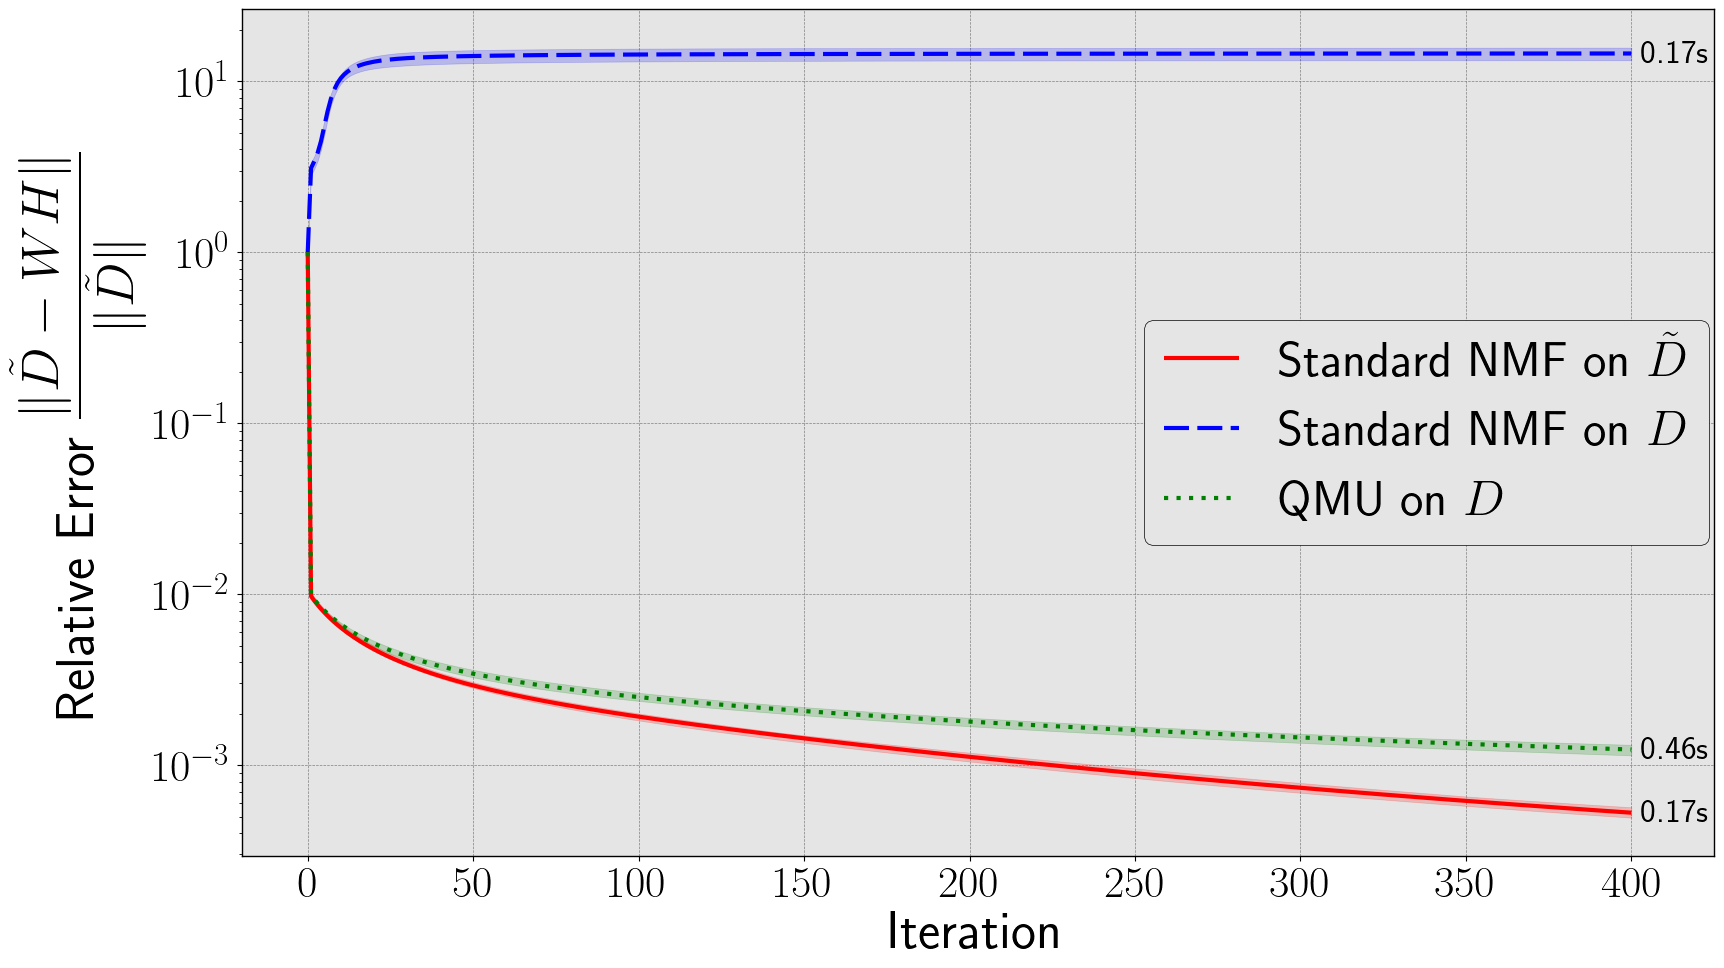

In [51]:
experiment = {
    r"Standard NMF on $\tilde{D}$": {
        "alg_func": nmf,
        "alg_params": {},
        "data_input": ("D_tilde", "D_tilde"),  # Use uncorrupted data for both error measurement and training.
        "model_rank": 40,
        "data_params": {"m": 120, "n": 100, "r": 40}
    },
    r"Standard NMF on $D$": {
        "alg_func": nmf,
        "alg_params": {},
        "data_input": ("D_tilde", "D"),  # Measure error on X but train on corrupted X.
        "model_rank": 40,
        "data_params": {"m": 120, "n": 100, "r": 40, "beta": 0.2}
    },
    r"QMU on $D$": {
        "alg_func": qmu,
        "alg_params": {"q": 0.8},
        "data_input": ("D_tilde", "D"),
        "model_rank": 40,
        "data_params": {"m": 120, "n": 100, "r": 40, "beta": 0.2}
    }
}

# Run the experiments:
run_experiments(num_runs=10, num_iterations=400,
                          experiment=experiment, data_gen_func=generate_synthetic_matrix,
                          base_seed=42, output="Error Plot")

### Relative error against corrupted and uncorrupted data (Figure 3)

In our second experiment, we compare the errors of the matrix factorization produced by QMU on $\mathbf{D}$ with model rank $r = 40$ measured against uncorrupted data $\tilde{\mathbf{D}}\in \mathbb{R}^{120 \times 100}$ with rank $\hat{r} = 40$ and corrupted data $\mathbf{D}$ with corruption rate $\beta = 0.1$.

The error plot generated below demonstrates that QMU does not fit to the corrupted data $\mathbf{D}$ but instead fits to the uncorrupted data $\tilde{\mathbf{D}}$, despite not being provided this uncorrupted input, indicating it is able to identify and ignore the corrupted entries.

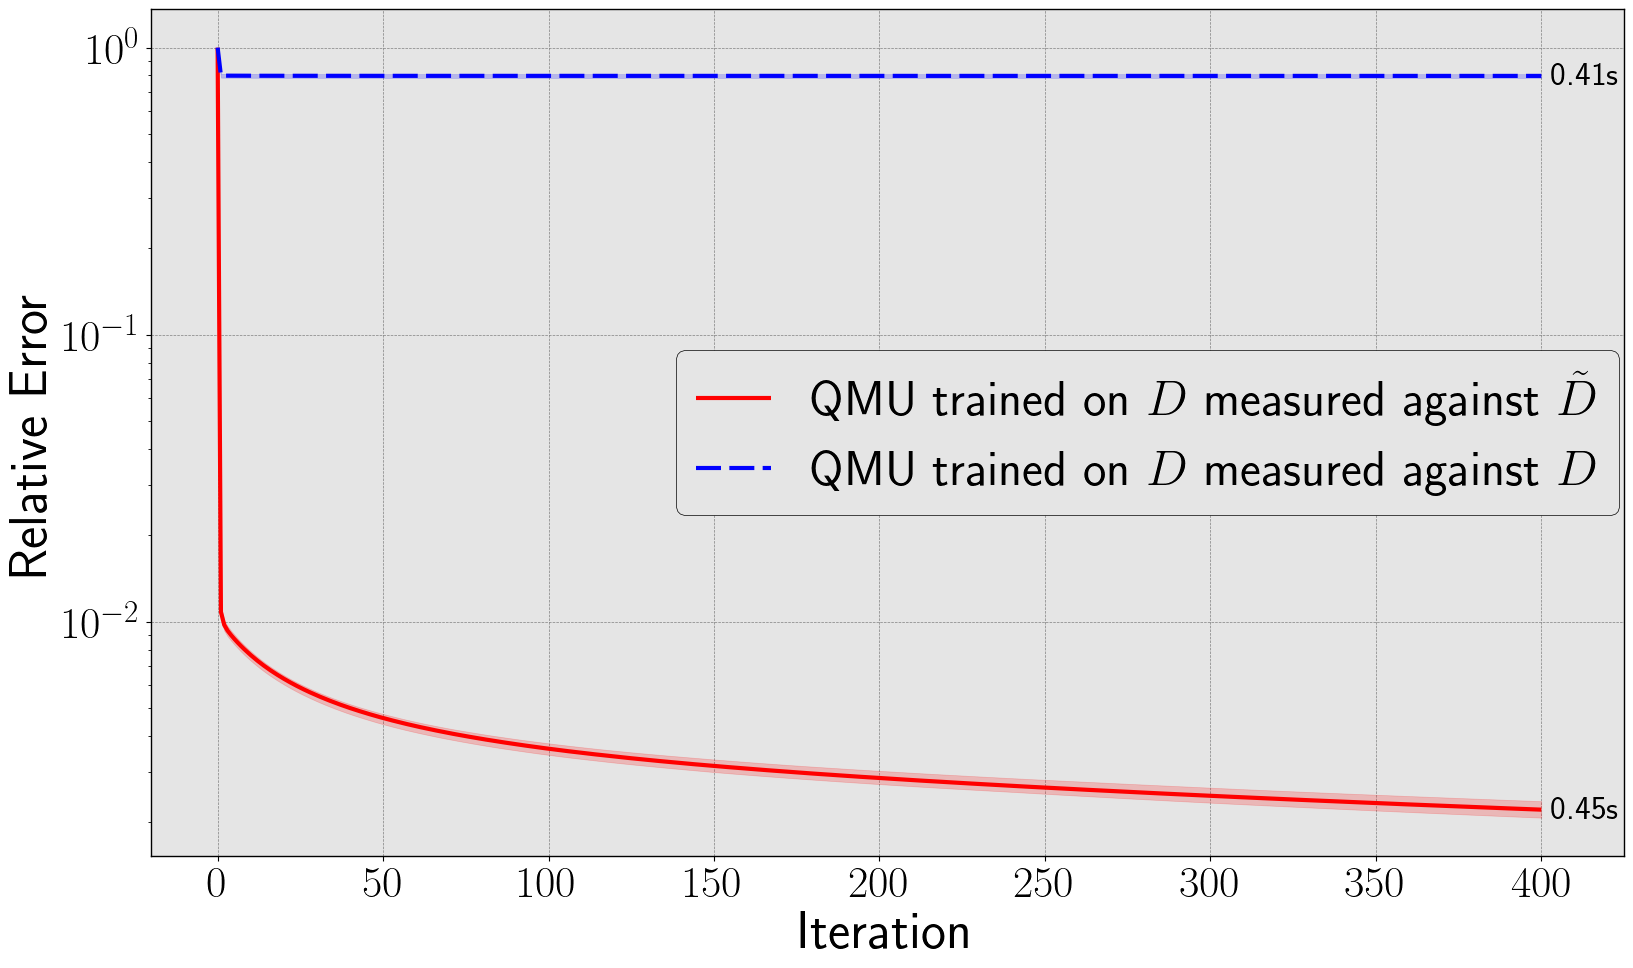

In [61]:
experiment = {
    r"QMU trained on $\displaystyle D$ measured against $\displaystyle \tilde{D}$": {
        "alg_func": qmu,
        "alg_params": {"q": 0.9},
        "data_input": ("D_tilde", "D_tilde"),
        "model_rank": 40,
        "data_params": {"m": 120, "n": 100, "r": 40, "beta": 0.1}
    },
    r"QMU trained on $\displaystyle D$ measured against $\displaystyle D$": {
        "alg_func": qmu,
        "alg_params": {"q": 0.9},
        "data_input": ("D", "D"),
        "model_rank": 40,
        "data_params": {"m": 120, "n": 100, "r": 40, "beta": 0.1}
    },
}

run_experiments(num_runs=10, num_iterations=400,
                          experiment=experiment, data_gen_func=generate_synthetic_matrix,
                          base_seed=42, output="Error Plot", y_lab="Relative Error")

### Varying quantile $q$ with fixed corruption rate $\beta$ (Figure 4)

In this experiment, we vary the quantile hyperparameter $q$ while holding the data corruption rate $\beta$ constant at $\beta = 0.2$. We once again generate uncorrupted data $\tilde{\mathbf{D}}\in \mathbb{R}^{120 \times 100}$ with rank $\hat{r} = 40$ and corrupted data $\mathbf{D}$ with corruption rate $\beta = 0.2$, and match the model rank $r=40$. The plot generated below illustrates that quantile $q = 0.8 = 1 - \beta$ performs best, while when too many entries are masked ($1-q > \beta$) the method performs slightly worse, and when we fail to mask the corruptions ($1-q < \beta$) the method diverges. This result highlights the need to select a conservative quantile $q$; however, in real-world contexts, this may be challenging to determine.

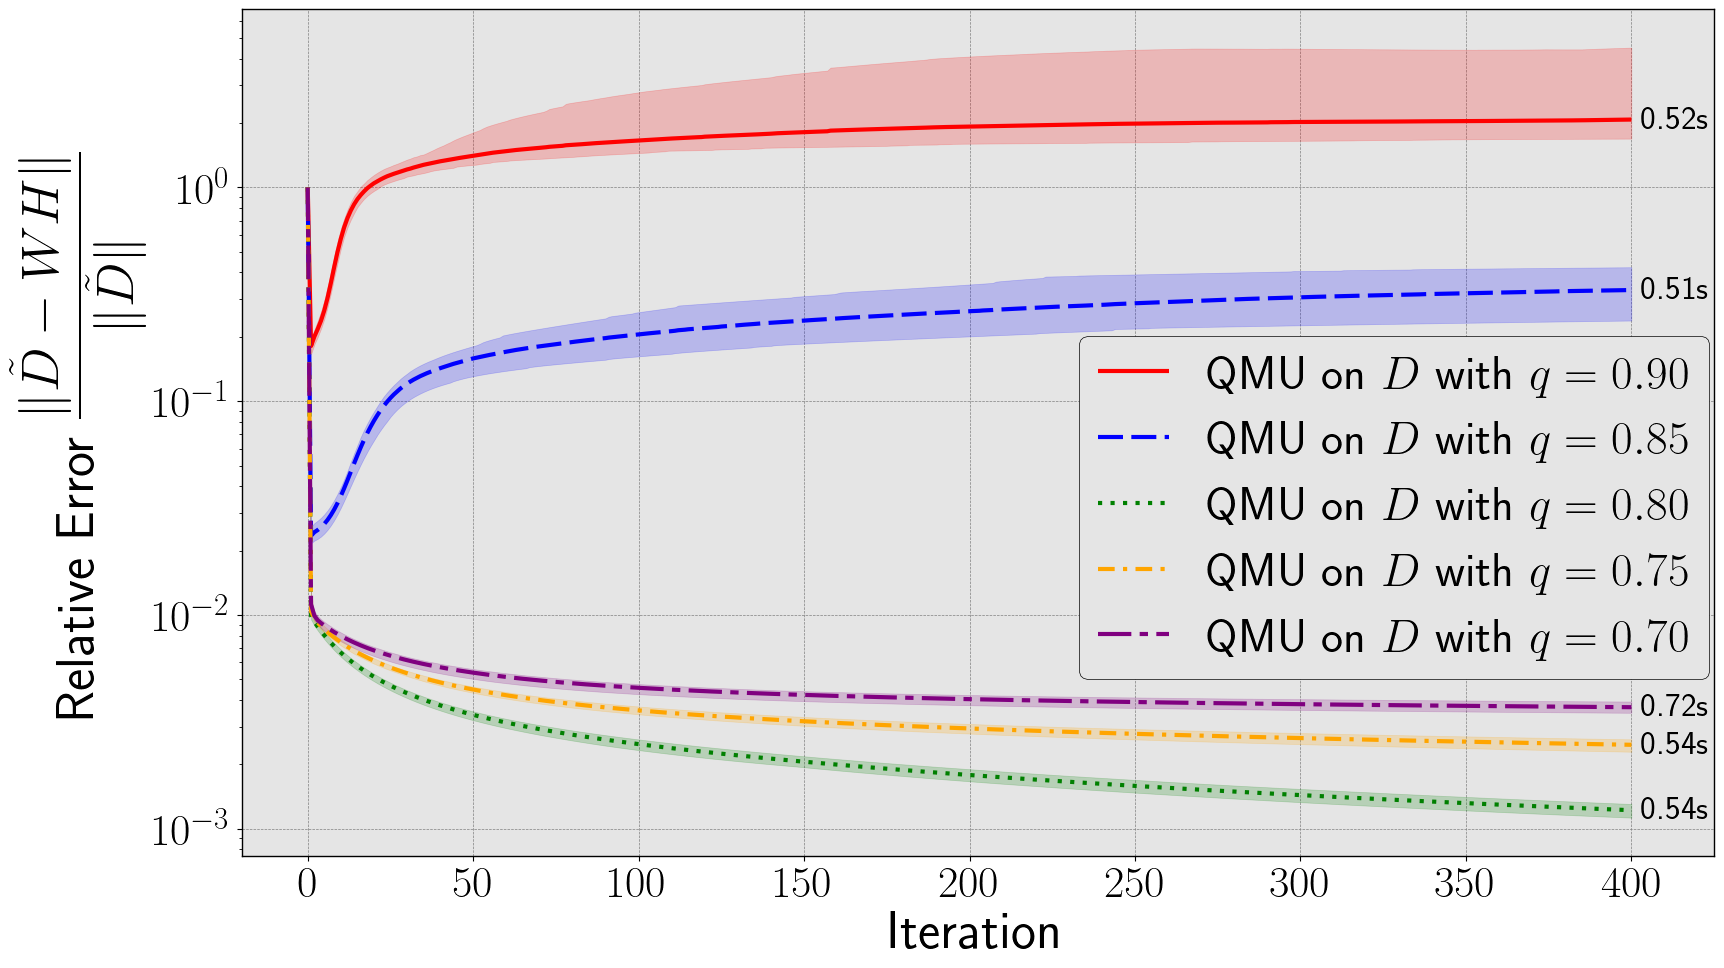

In [132]:
experiment = {}
for q in [0.90, 0.85, 0.80, 0.75, 0.70]:
    experiment[rf"QMU on $\displaystyle D$ with $\displaystyle q = {q:.2f}$"] = {
        "alg_func": qmu,
        "alg_params": {"q": q},
        "data_input": ("D_tilde", "D"),
        "model_rank": 40,
        "data_params": {"m": 120, "n": 100, "r": 40, "beta": 0.20}
    }

run_experiments(num_runs=10, num_iterations=400,
                          experiment=experiment, data_gen_func=generate_synthetic_matrix,
                          base_seed=42, output="Error Plot")

### Varying $\beta$ with fixed $q$

Similar to the previous experiment, in this experiment we measure the error when applying our method with fixed $q = 0.15$ and vary $\beta$. We once again use matrix dimensions $120 \times 100$ with true data rank $40$, and match the model rank to also be $r=40$. The plot generated below illustrates the error results. Consistent with the previous result, the model performs optimally for $1-q = \beta$, slightly worse when $1-q > \beta$, and significantly worse when $1-q < \beta$.

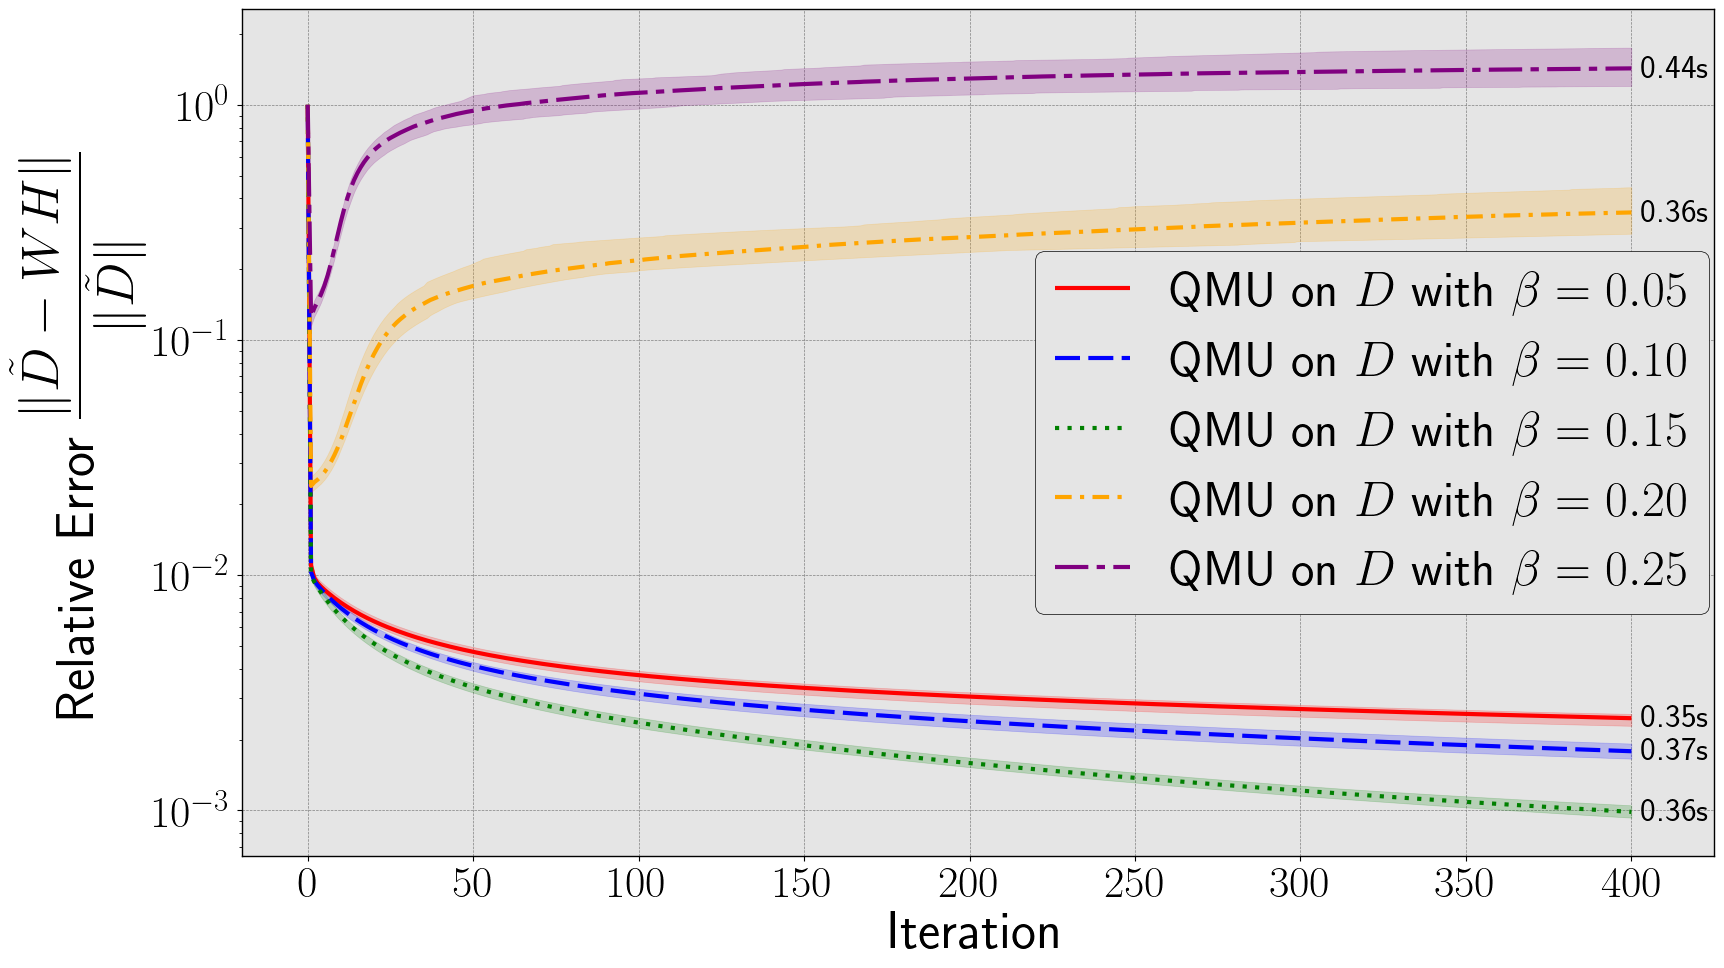

In [54]:
experiment = {}
for beta in [0.05, 0.1, 0.15, 0.2, 0.25]:
    experiment[rf"QMU on $\displaystyle D$ with $\displaystyle \beta = {beta:.2f}$"] = {
        "alg_func": qmu,
        "alg_params": {"q": 0.85},
        "data_input": ("D_tilde", "D"),  # Use uncorrupted data for both error measurement and training.
        "model_rank": 40,
        "data_params": {"m": 120, "n": 100, "r": 40, "beta": beta}
    }

# Run the experiments:
run_experiments(num_runs=10, num_iterations=400,
                          experiment=experiment, data_gen_func=generate_synthetic_matrix,
                          base_seed=42, output="Error Plot")

### Varying corruption rate $\beta$ and quantile $q$ together (Figure 5)

In this experiment, we vary the quantile $q$ and the corruption rate $\beta$ together such that $q + \beta = 1$. We once again generate uncorrupted data $\tilde{\mathbf{D}}\in \mathbb{R}^{120 \times 100}$ with rank $\hat{r} = 40$, and match the model rank $r=40$. The plot generated below displays the training error of the different learned models for each combination tested of $q$ and $\beta$. We observe that error increases as corruption rate $\beta$ increases, however, this error increase is gradual as only slightly less information is available in each iteration.

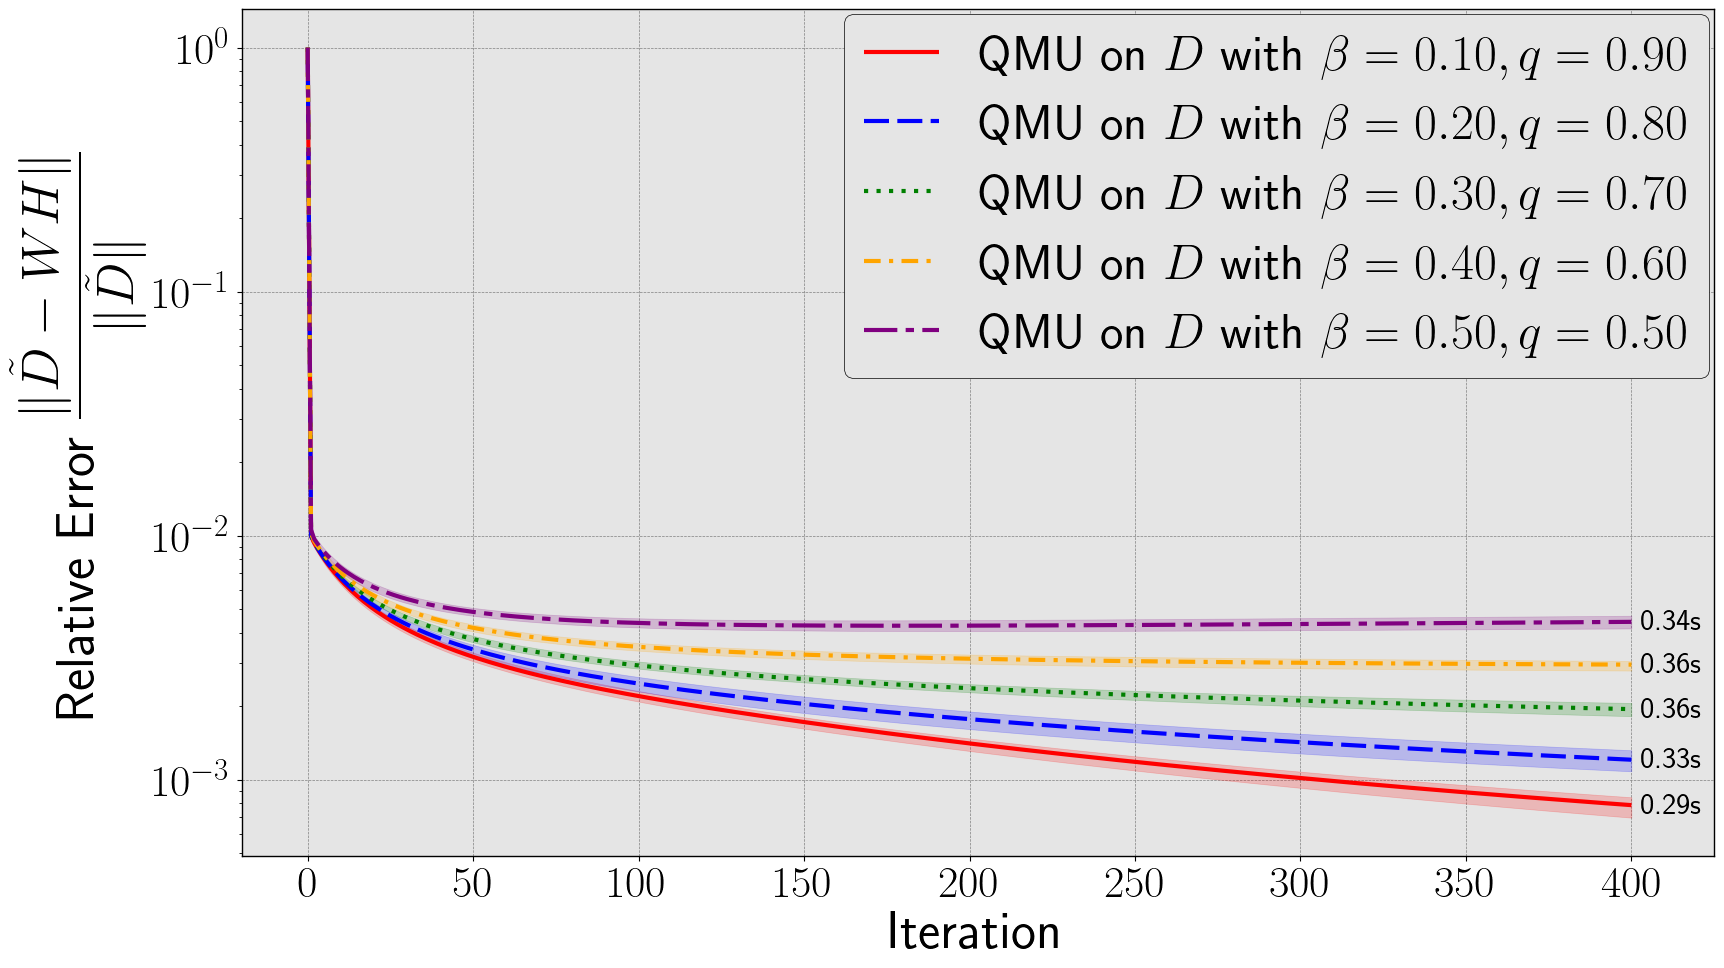

In [121]:
experiment = {}
# for beta in [0.05, 0.1, 0.15, 0.2, 0.25]:
for beta in [0.1, 0.2, 0.3, 0.4, 0.5]:
    experiment[rf"QMU on $\displaystyle D$ with $\displaystyle \beta = {beta:.2f}, q = {(1 - beta):.2f}$"] = {
        "alg_func": qmu,
        "alg_params": {"q": 1 - beta},
        "data_input": ("D_tilde", "D"),  # Use uncorrupted data for both error measurement and training.
        "model_rank": 40,
        "data_params": {"m": 120, "n": 100, "r": 40, "beta": beta}
    }

# Run the experiments:
run_experiments(num_runs=10, num_iterations=400,
                          experiment=experiment, data_gen_func=generate_synthetic_matrix,
                          base_seed=42, output="Error Plot")

### Varying model rank $r$ (Figure 6)

In this experiment, we measure the effectiveness of QMU on corrupted synthetic data when varying the model rank $r$. We once again generate uncorrupted data $\tilde{\mathbf{D}}\in \mathbb{R}^{120 \times 100}$ with rank $\hat{r} = 40$ and corrupted data $\mathbf{D}$ with corruption rate $\beta = 0.1$. We run QMU on $\mathbf{D}$ with model ranks $r \in \{10, 20, 40, 60\}$ and measure error against $\tilde{\mathbf{D}}$. As shown in the error plot generated below, model performance suffers if we underestimate the rank of the data, but overestimating the rank does not result in a significant difference in performance.

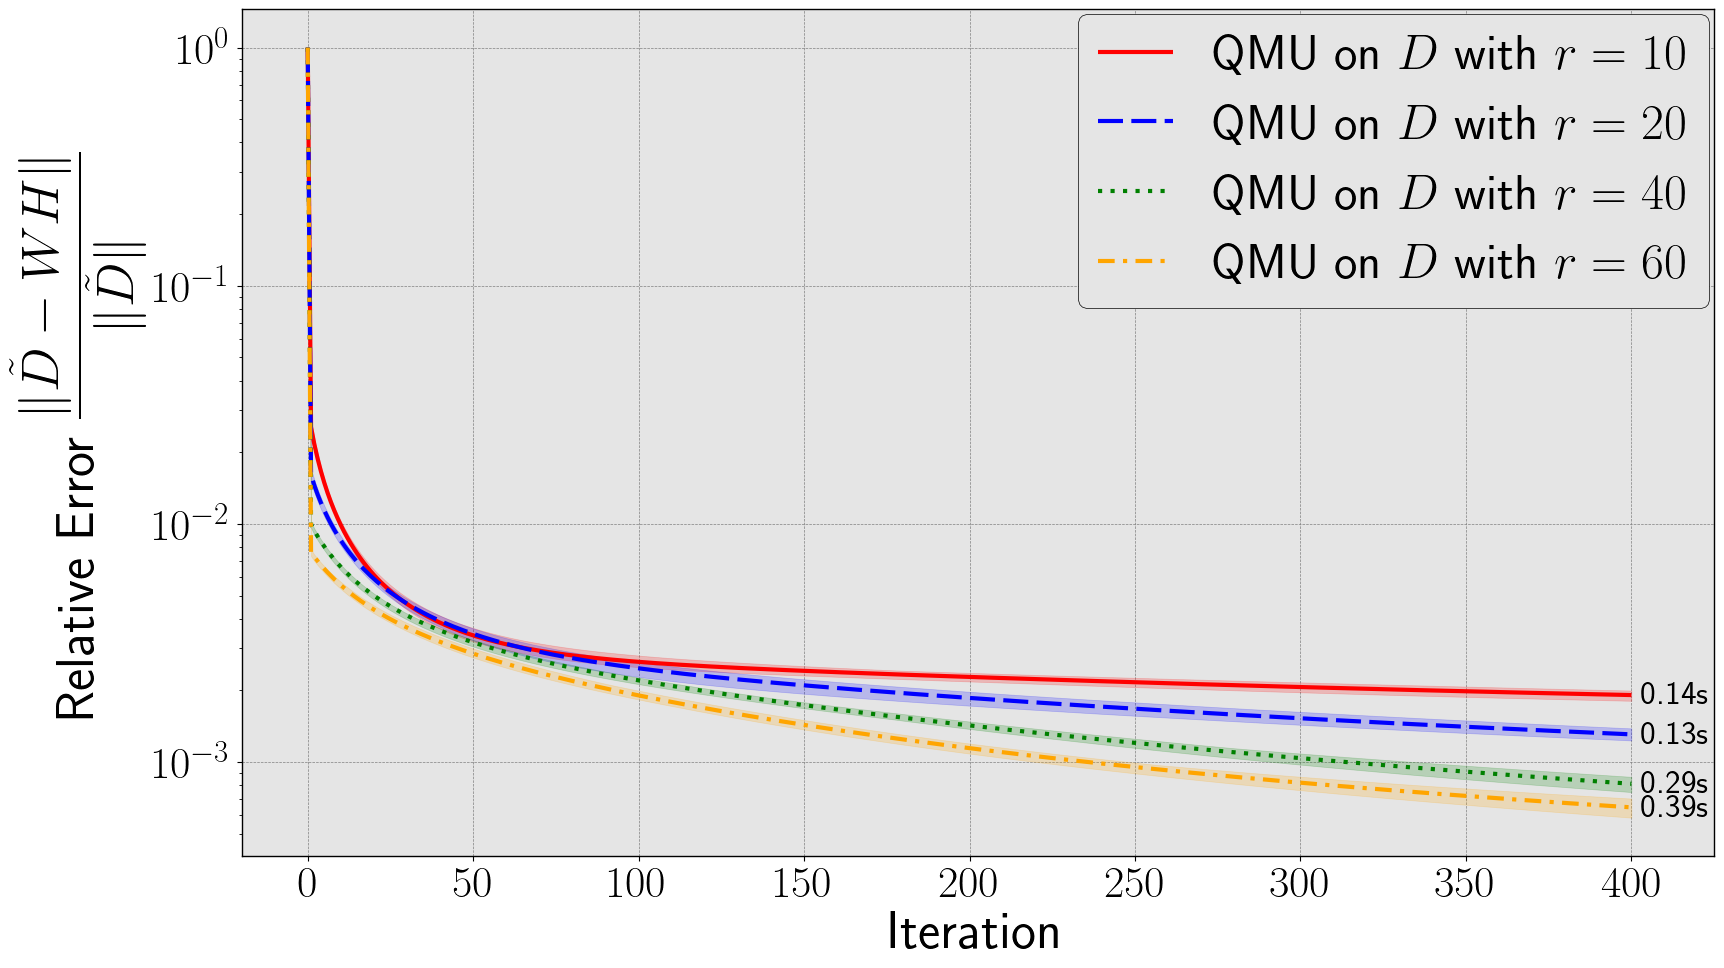

In [64]:
experiment = {}
for r in [10, 20, 40, 60]:
    experiment[rf"QMU on $\displaystyle D$ with $\displaystyle r = {r}$"] = {
        "alg_func": qmu,
        "alg_params": {"q": 0.9},
        "data_input": ("D_tilde", "D"),
        "model_rank": r,
        "data_params": {"m": 120, "n": 100, "r": 40, "beta": 0.1}
    }

# Run the experiments:
run_experiments(num_runs=10, num_iterations=400,
                          experiment=experiment, data_gen_func=generate_synthetic_matrix,
                          base_seed=42, output="Error Plot")

### Varying rank of the data

In this experiment, we measure the effectiveness of QMU on corrupted synthetic data when varying the rank of the data. Matrices $\tilde{\mathbf{D}}$ are randomly generated with ranks of 16, 24, 32, and 40 and dimensions $64\times 48$, and $10\%$ of their entries, chosen at random, are corrupted to produce $\mathbf{D}$. We run QMU on $\mathbf{D}$ of each rank, with the algorithm assuming a rank of 32, for 400 iterations and repeat this experiment 10 times. All errors were measured against $\tilde{\mathbf{D}}$. As shown in The error plot generated below, the model performance does not depend too much on the rank of the data, although it does seem to perform better on $\mathbf{D}$ with small rank.

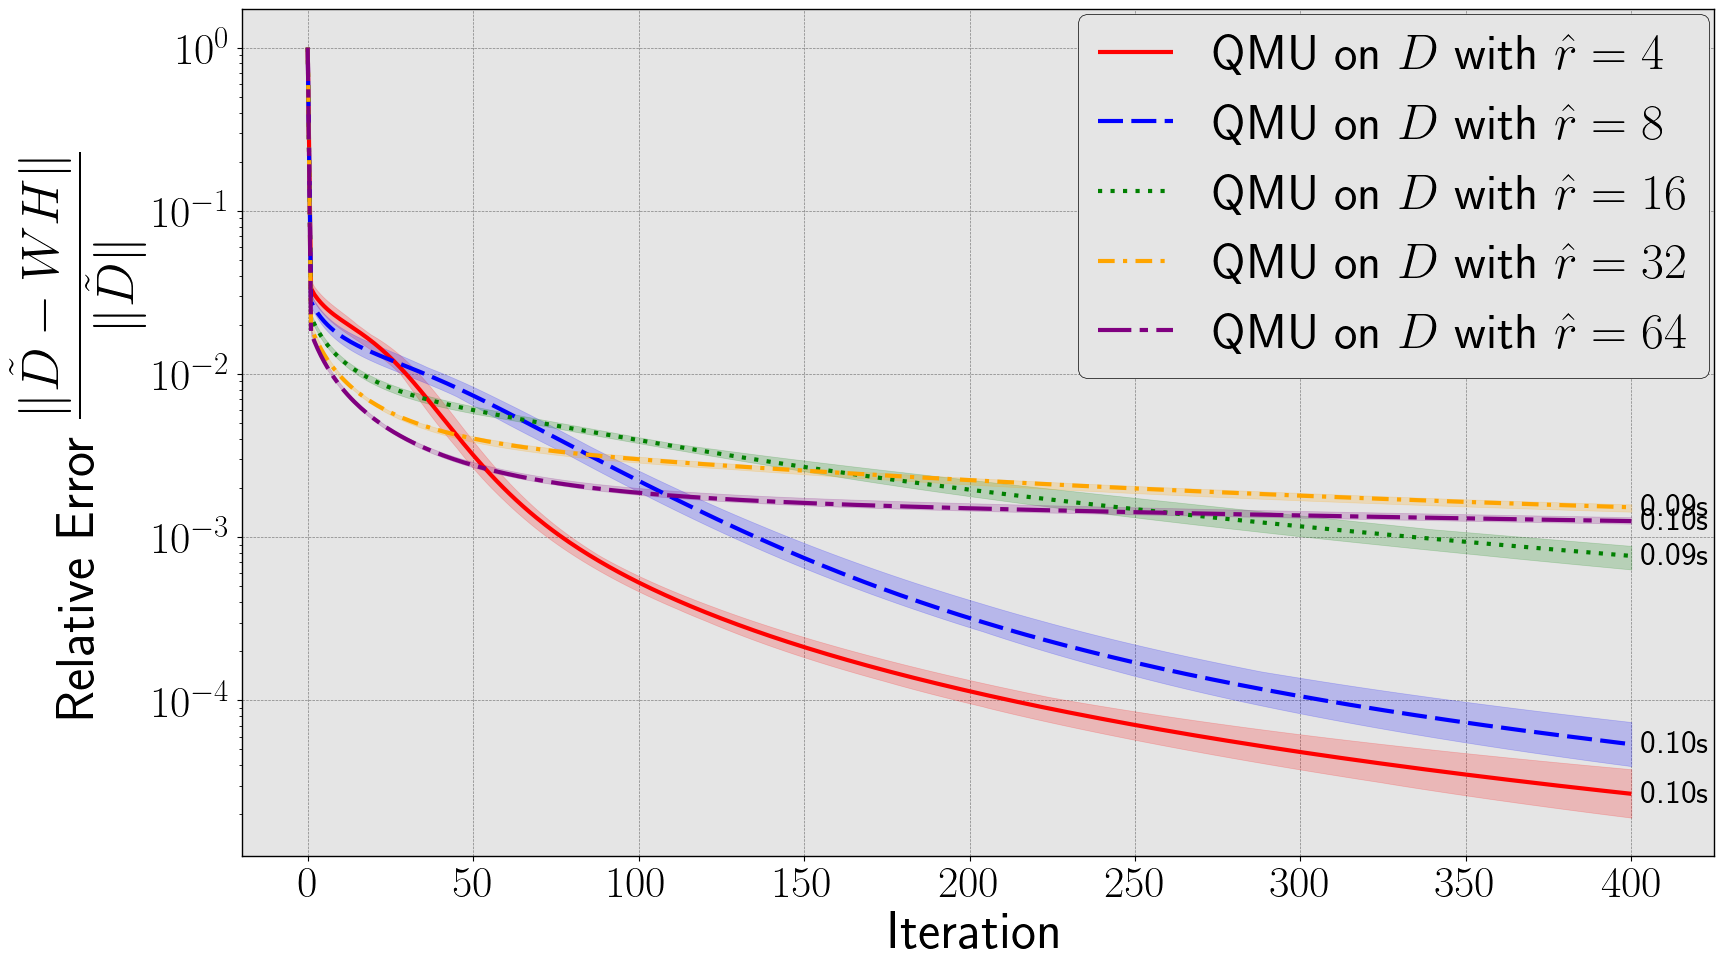

In [63]:
experiment = {}
for r in [4, 8, 16, 32, 64]:
    experiment[rf"QMU on $\displaystyle D$ with $\displaystyle \hat{{r}} = {r}$"] = {
        "alg_func": qmu,
        "alg_params": {"q": 0.9},
        "data_input": ("D_tilde", "D"),
        "model_rank": 16,
        "data_params": {"m": 120, "n": 100, "r": r, "beta": 0.1}
    }

# Run the experiments:
run_experiments(num_runs=10, num_iterations=400,
                          experiment=experiment, data_gen_func=generate_synthetic_matrix,
                          base_seed=42, output="Error Plot")

### Different Matrix Dimensions

In this experiment, we measure the effectiveness of QMU on corrupted data matrices generated with corruption rate $\beta = 0.1$ from uncorrupted matrices with the same rank, $\hat{r} = 20$, but different dimensions, $16 \times 12$, $32 \times 24$, $64\times 48$ and $128 \times 96$. We run QMU on each $\mathbf{D}$ with model rank $m / 4$, where $m$ is the first matrix dimension. All errors are measured against $\tilde{\mathbf{D}}$. As shown in The error plot generated below, the model error does not depend strongly on the dimensions of the data matrices. However, the model does take more time per iteration for larger matrices.

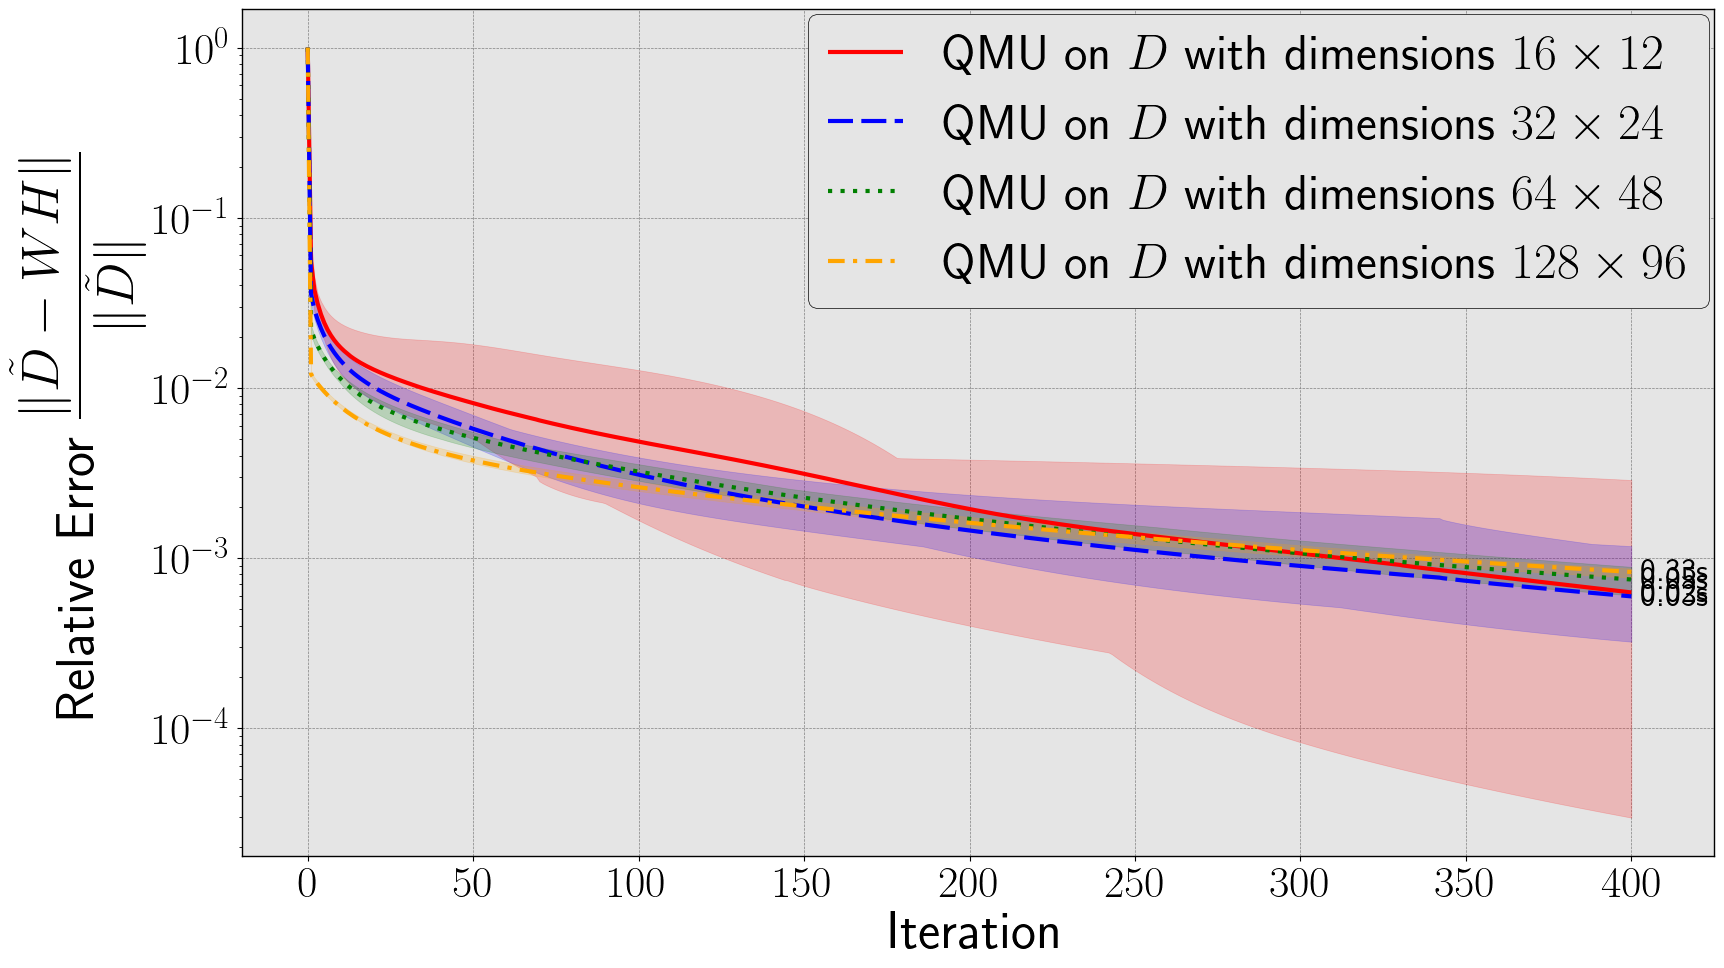

In [60]:
experiment = {}
for m, n in [(16, 12), (32, 24), (64, 48), (128, 96)]:
    experiment[rf"QMU on $\displaystyle D$ with dimensions $\displaystyle {m} \times {n}$"] = {
        "alg_func": qmu,
        "alg_params": {"q": 0.9},
        "data_input": ("D_tilde", "D"),
        "model_rank": m // 4,
        "data_params": {"m": m, "n": n, "r": m // 4, "beta": 0.1}
    }

# Run the experiments:
run_experiments(num_runs=10, num_iterations=400,
                          experiment=experiment, data_gen_func=generate_synthetic_matrix,
                          base_seed=42, output="Error Plot")

## Swimmer Data

In this section, we apply the proposed method to a toy image dataset called the $\texttt{Swimmer}$ dataset, which is composed of $11 \times 20$-pixel images.

We let $\tilde{\mathbf{D}}$ be the matrix with columns that are the vectorized images from the $\texttt{Swimmer}$ dataset, and note that this matrix has data rank $\hat{r} = 16$.

### Standard Multiplicative Updates vs. QMU (Figure 7)

In this experiment, we test QMU on the $\texttt{Swimmer}$ dataset to better understand its effectiveness on real data. We use a model rank of $r = 17$ and set $q = 0.95$, and train our models for 400 iterations. We build $\mathbf{D}$ by corrupting $\beta = 0.05$ of the entries with values drawn from $|\mathcal{N}(0,25)|$; Subfigure (c) presents one of the $\texttt{Swimmer}$ figures after corruption. The figure below illustrates the effectiveness of standard multiplicative updates and QMU on reconstructing these images in the presence of additive corruptions. We can see that while the standard multiplicative updates algorithm reconstructs uncorrupted data well (b), when applied to corrupted data, the reconstruction by standard multiplicative updates (d) is poor. In contrast, QMU masks these corruptions and achieves a much better reconstruction (e).


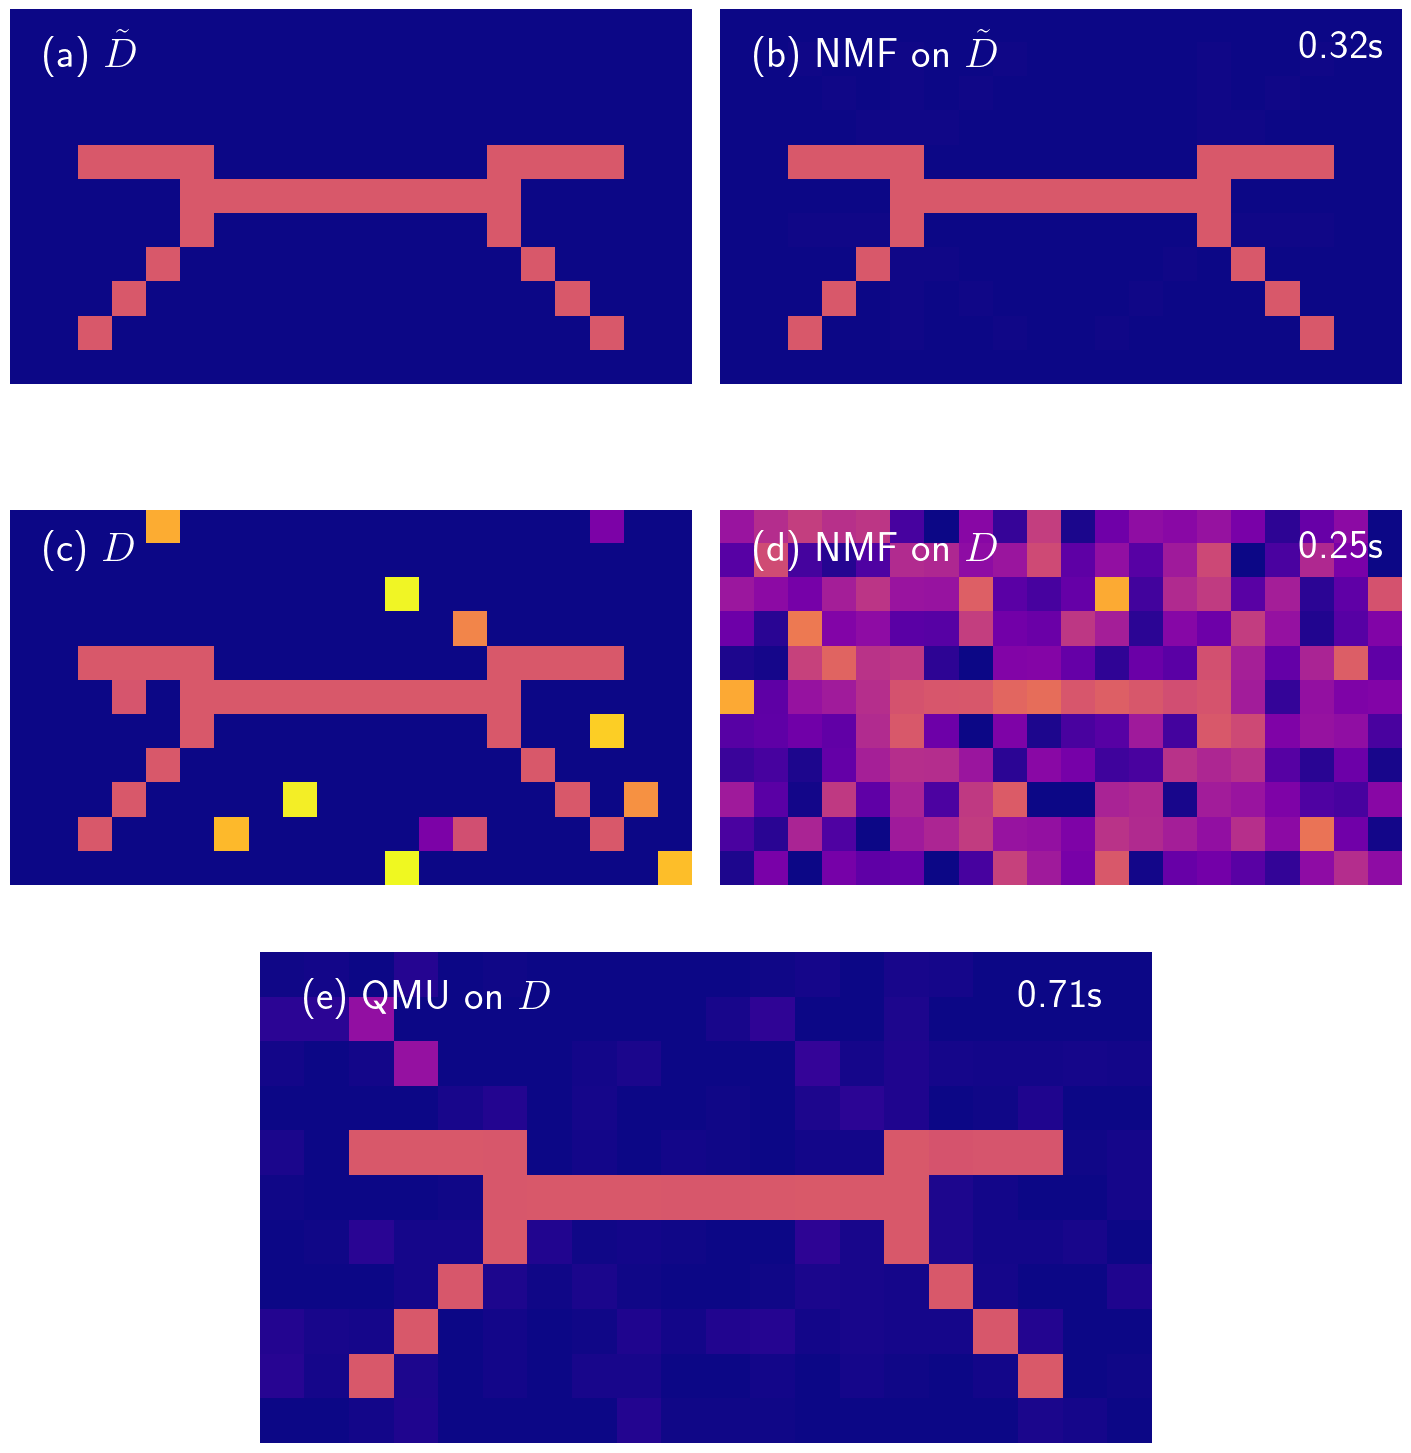

In [151]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import numpy as np

# Assume the following functions are defined elsewhere in your code:
# load_swimmer_dataset, nmf, qmu

# Load the dataset and compute matrices with NMF and QMU
D, D_tilde = load_swimmer_dataset(beta=0.05, corruption_scale=5)

W_nmf_uncorr, H_nmf_uncorr, _, _, runtime_nmf_uncorr = nmf(D_tilde, D_tilde, 400, 17, seed=42)
W_nmf_corr, H_nmf_corr, _, _, runtime_nmf_corr = nmf(D_tilde, D, 400, 17, seed=42)
W_qmu, H_qmu, _, _, runtime_qmu = qmu(D_tilde, D, 400, 17, 0.95, seed=42)

# Compute the five matrices of interest:
mat_a = np.reshape(D_tilde[:, 17], (11, 20))
mat_b = np.reshape((W_nmf_uncorr @ H_nmf_uncorr)[:, 17], (11, 20))
mat_c = np.reshape(D[:, 17], (11, 20))
mat_d = np.reshape((W_nmf_corr @ H_nmf_corr)[:, 17], (11, 20))
mat_e = np.reshape((W_qmu @ H_qmu)[:, 17], (11, 20))

# Add epsilon and create log-normalized data
epsilon = 1e-1  # Small value to avoid log(0)
matrices = [mat + epsilon for mat in [mat_a, mat_b, mat_c, mat_d, mat_e]]

# Set up a figure with 3 rows and 2 columns:
fig = plt.figure(constrained_layout=True, figsize=(14, 15))
gs = gridspec.GridSpec(3, 2, figure=fig)

# Create subplots:
axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]),
        fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1]),
        fig.add_subplot(gs[2, :])]

captions = [r'(a) $\tilde{D}$', r'(b) NMF on $\tilde{D}$', r'(c) $D$', r'(d) NMF on $D$', r'(e) QMU on $D$']
runtimes = ['', f"{runtime_nmf_uncorr:.2f}s", '', f"{runtime_nmf_corr:.2f}s", f"{runtime_qmu:.2f}s"]

# Compute global min/max with epsilon
global_min = min(np.min(M) for M in matrices)
global_max = max(np.max(M) for M in matrices)

# Log normalization
norm = colors.LogNorm(vmin=global_min, vmax=global_max)

# Plot each matrix
for ax, M, caption, runtime in zip(axes, matrices, captions, runtimes):
    im = ax.imshow(M, cmap='plasma', norm=norm)
    ax.axis('off')
    ax.text(0.05, 0.95, caption,
            transform=ax.transAxes,
            fontsize=30, fontweight='bold',
            fontfamily='sans-serif',
            color='white',
            verticalalignment='top')
    ax.text(0.85, 0.95, runtime,
            transform=ax.transAxes,
            fontsize=30, fontweight='bold',
            fontfamily='sans-serif',
            color='white',
            verticalalignment='top')

plt.show()

### QMU Corrupted vs Uncorrupted Error Measures

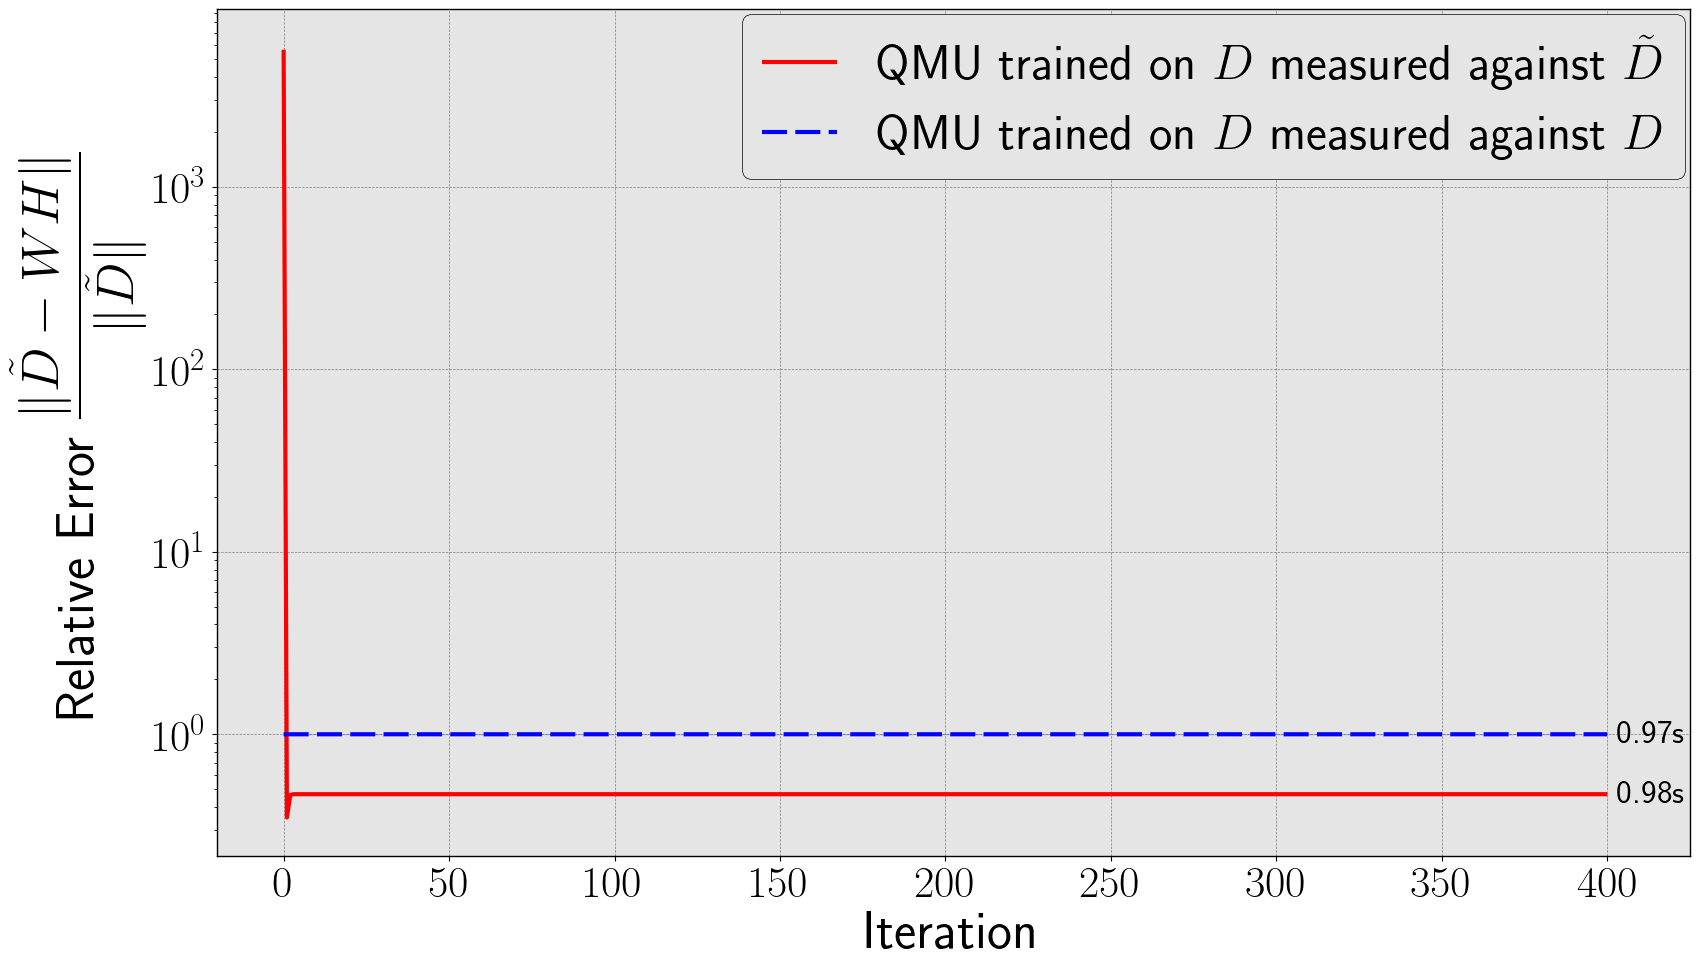

In [69]:
experiment = {
    r"QMU trained on $\displaystyle D$ measured against $\displaystyle \tilde{D}$": {
        "alg_func": qmu,
        "alg_params": {"q": 0.9},
        "data_input": ("D_tilde", "D_tilde"),
        "model_rank": 40,
        "data_params": {"beta": 0.1}
    },
    r"QMU trained on $\displaystyle D$ measured against $\displaystyle D$": {
        "alg_func": qmu,
        "alg_params": {"q": 0.9},
        "data_input": ("D", "D"),
        "model_rank": 40,
        "data_params": {"beta": 0.1}
    },
}

run_experiments(num_runs=10, num_iterations=400,
                          experiment=experiment, data_gen_func=load_swimmer_dataset,
                          base_seed=42, output="Error Plot")

### Different Guesses for $q$

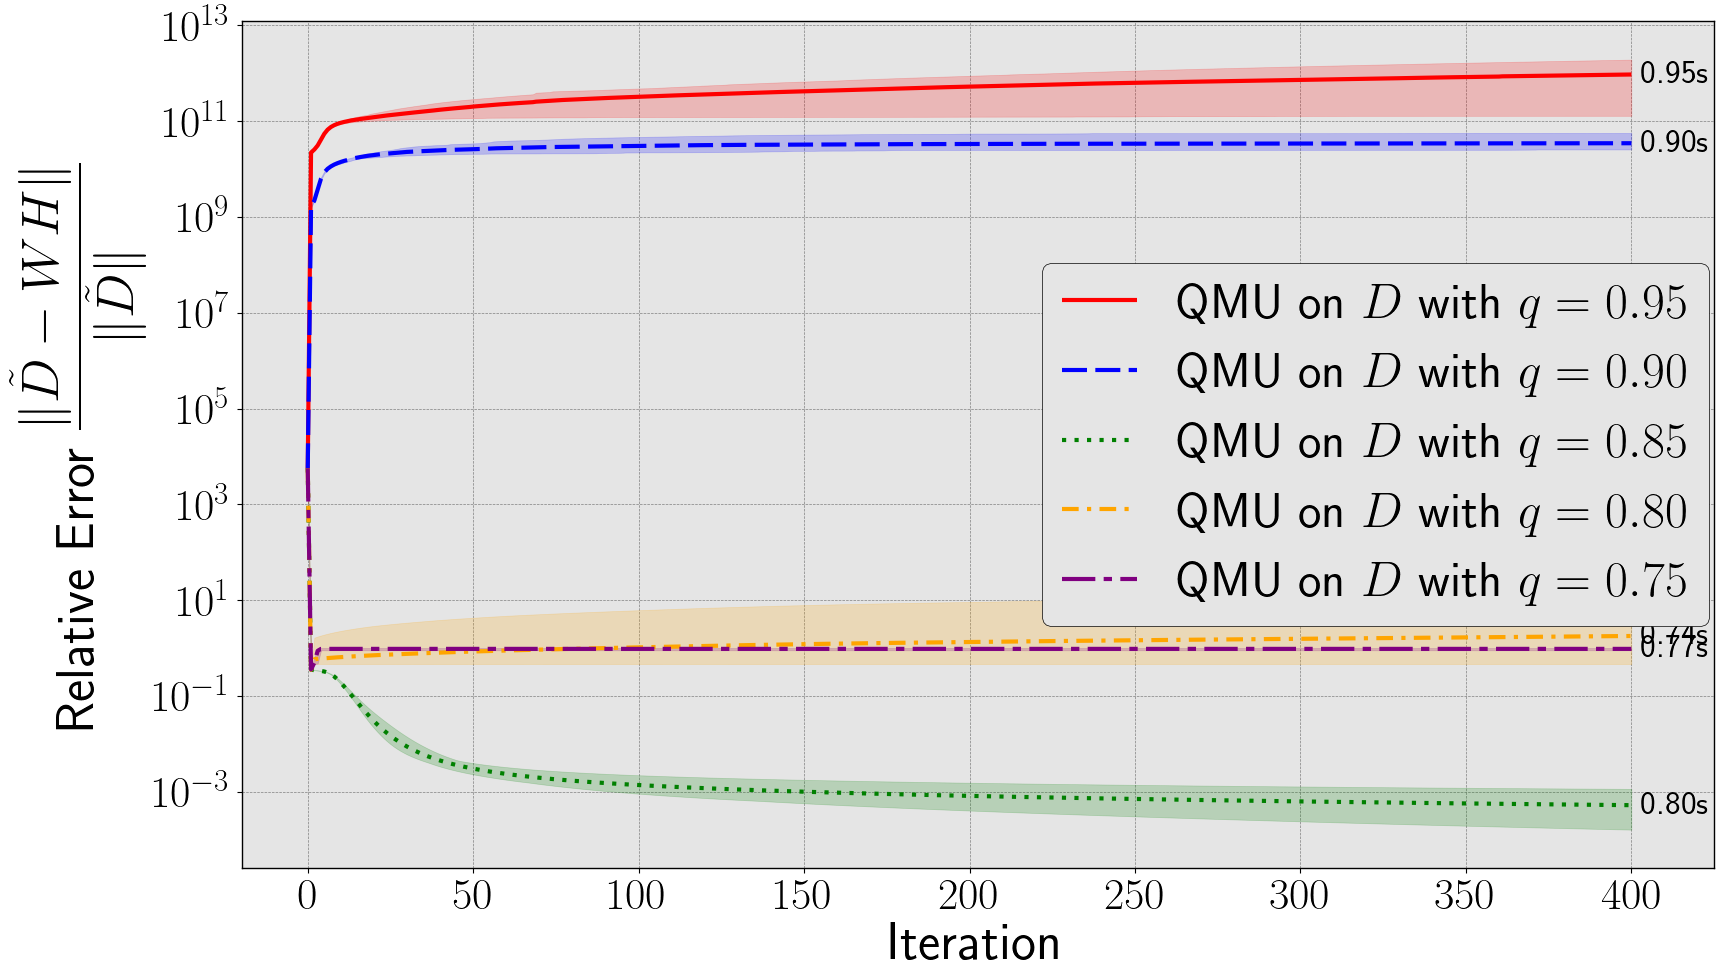

In [74]:
experiment = {}
for q in [0.95, 0.9, 0.85, 0.8, 0.75]:
    experiment[rf"QMU on $\displaystyle D$ with $\displaystyle q = {q:.2f}$"] = {
        "alg_func": qmu,
        "alg_params": {"q": q},
        "data_input": ("D_tilde", "D"),
        "model_rank": 40,
        "data_params": {"beta": 0.15}
    }

run_experiments(num_runs=10, num_iterations=400,
                          experiment=experiment, data_gen_func=load_swimmer_dataset,
                          base_seed=42, output="Error Plot")

### Fixed $q$, varying $\beta$

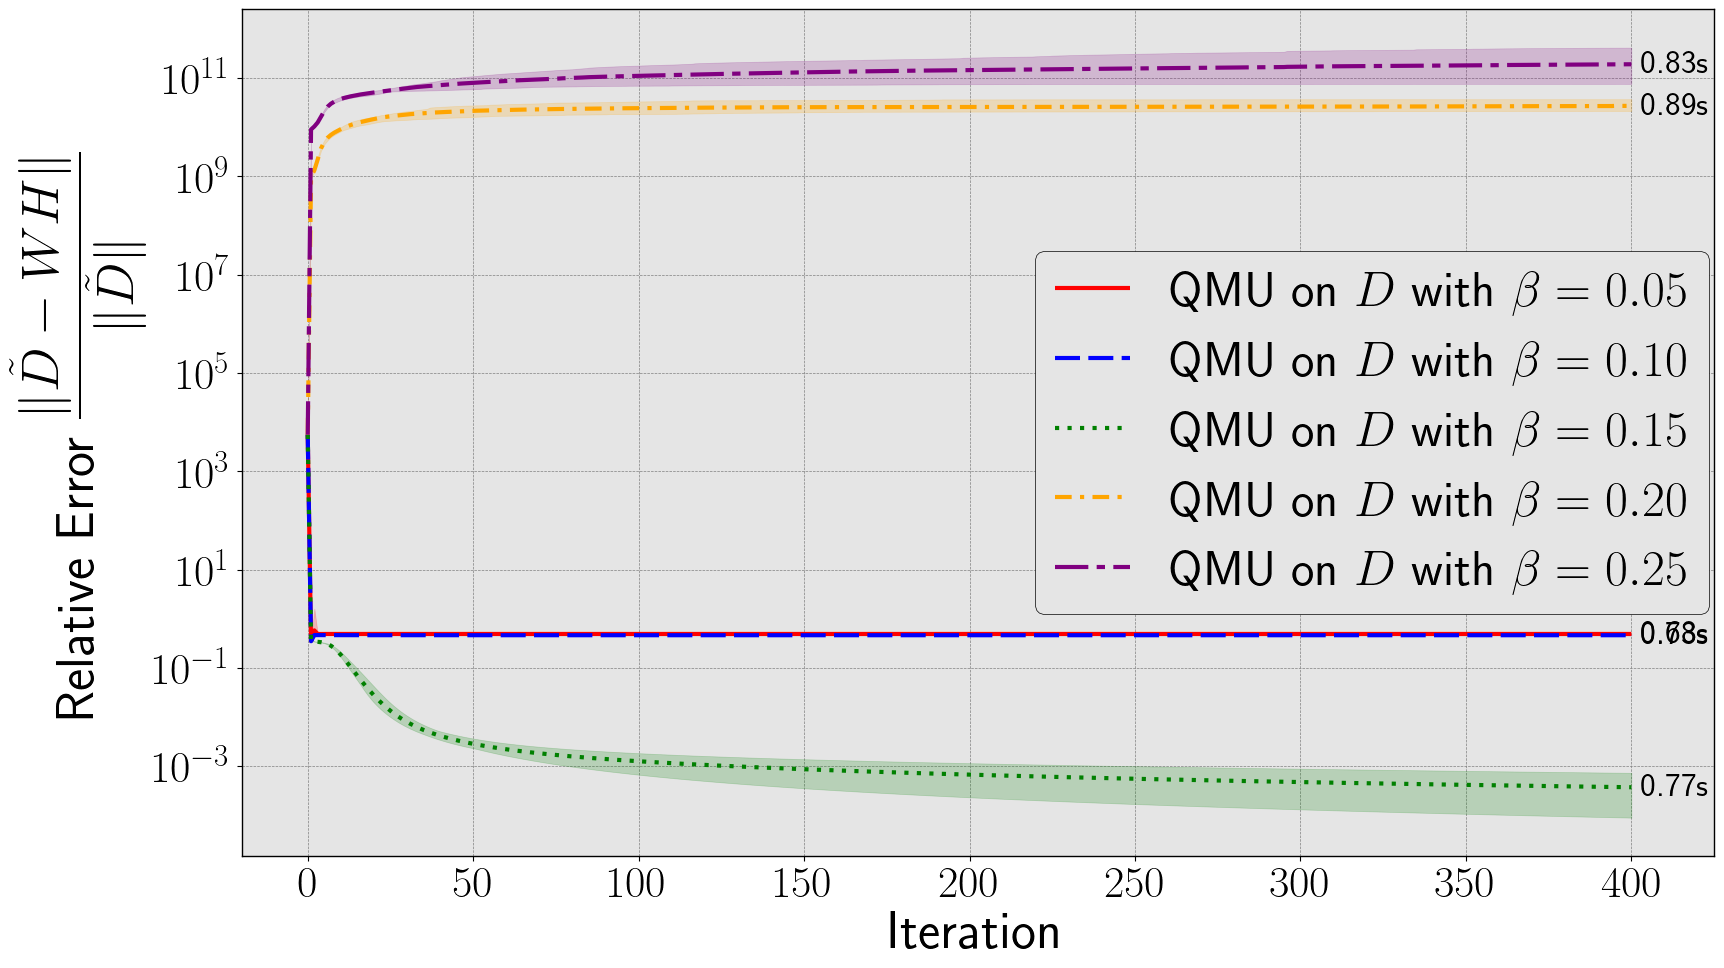

In [75]:
experiment = {}
for beta in [0.05, 0.1, 0.15, 0.2, 0.25]:
    experiment[rf"QMU on $\displaystyle D$ with $\displaystyle \beta = {beta:.2f}$"] = {
        "alg_func": qmu,
        "alg_params": {"q": 0.85},
        "data_input": ("D_tilde", "D"),
        "model_rank": 40,
        "data_params": {"beta": beta}
    }

run_experiments(num_runs=10, num_iterations=400,
                          experiment=experiment, data_gen_func=load_swimmer_dataset,
                          base_seed=42, output="Error Plot")

### Varying $q$ and $\beta$ together

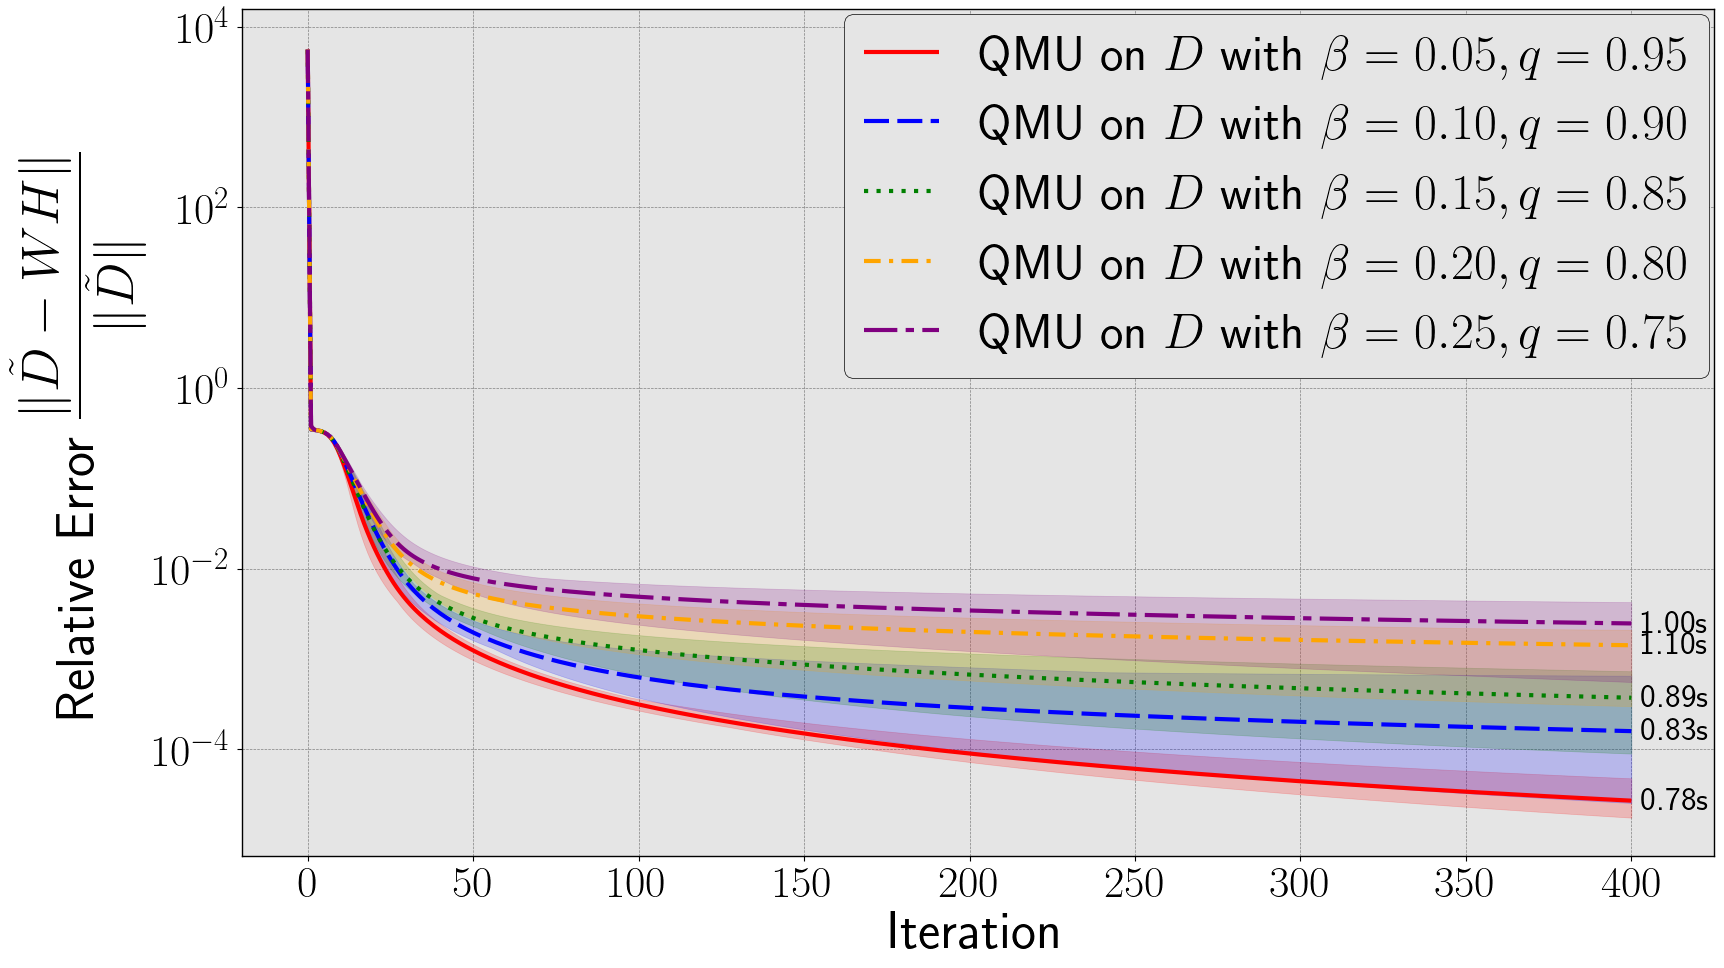

In [76]:
experiment = {}
for beta in [0.05, 0.1, 0.15, 0.2, 0.25]:
    experiment[rf"QMU on $\displaystyle D$ with $\displaystyle \beta = {beta:.2f}, q = {(1 - beta):.2f}$"] = {
        "alg_func": qmu,
        "alg_params": {"q": 1 - beta},
        "data_input": ("D_tilde", "D"),  # Use uncorrupted data for both error measurement and training.
        "model_rank": 40,
        "data_params": {"beta": beta}
    }

# Run the experiments:
run_experiments(num_runs=10, num_iterations=400,
                          experiment=experiment, data_gen_func=load_swimmer_dataset,
                          base_seed=42, output="Error Plot")

### Different Model Ranks

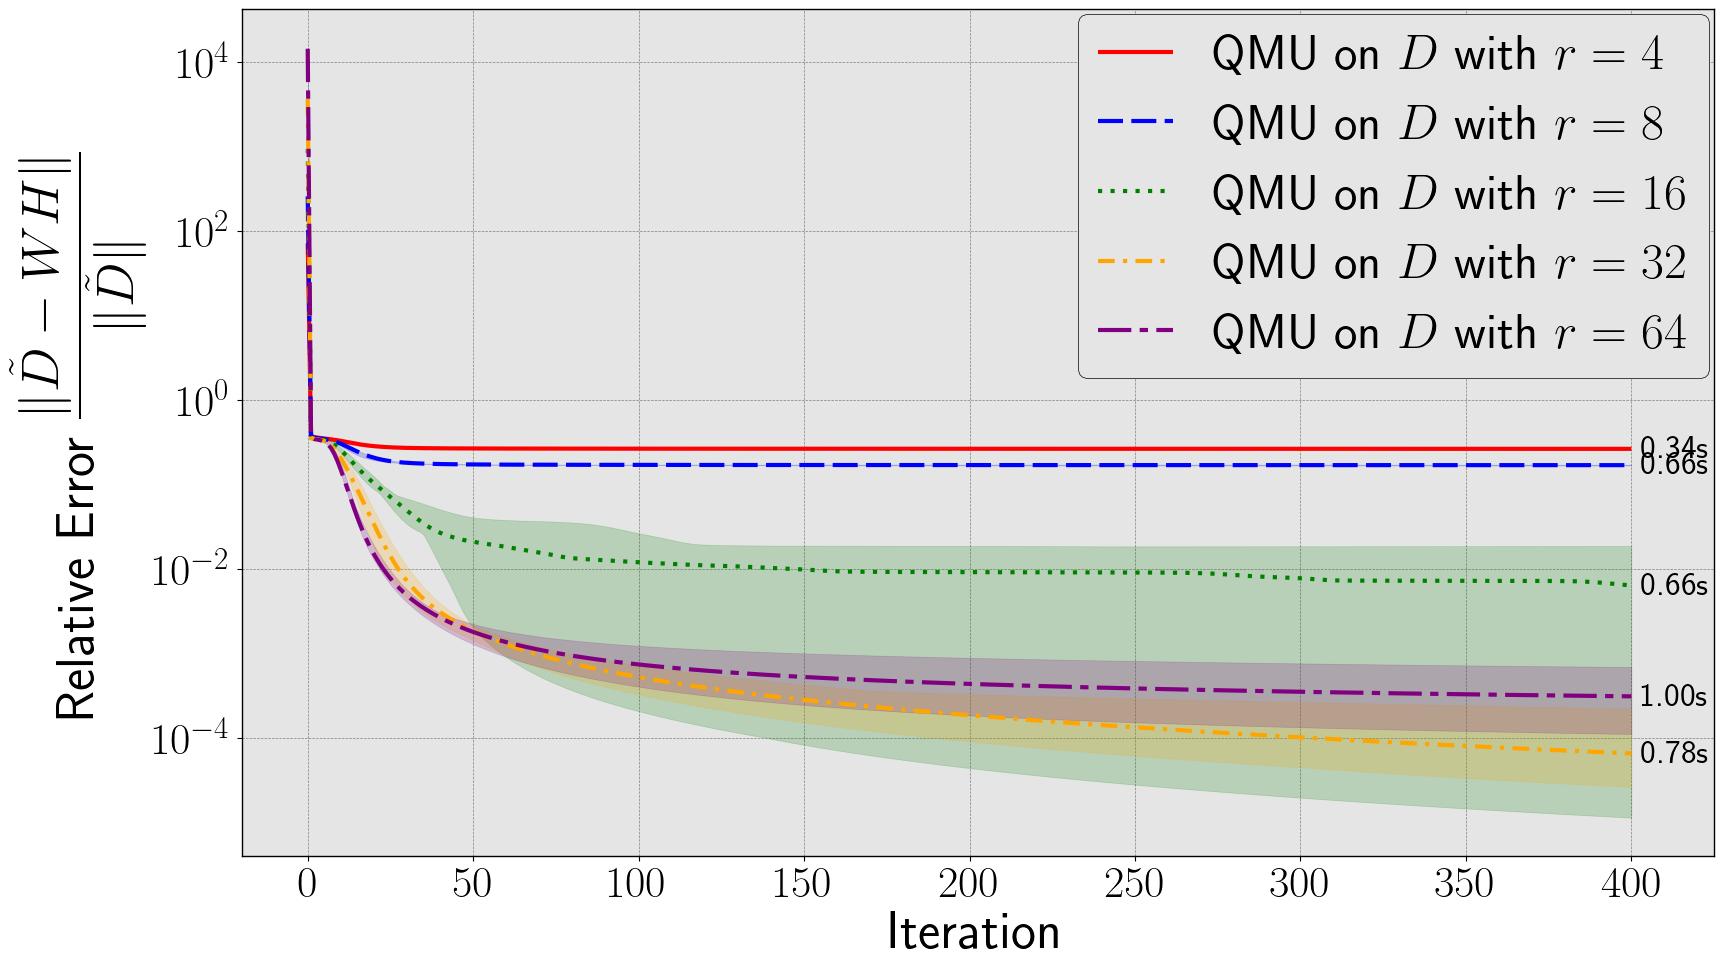

In [77]:
experiment = {}
for r in [4, 8, 16, 32, 64]:
    experiment[rf"QMU on $\displaystyle D$ with $\displaystyle r = {r}$"] = {
        "alg_func": qmu,
        "alg_params": {"q": 0.9},
        "data_input": ("D_tilde", "D"),
        "model_rank": r,
        "data_params": {"beta": 0.1}
    }

# Run the experiments:
run_experiments(num_runs=10, num_iterations=400,
                          experiment=experiment, data_gen_func=load_swimmer_dataset,
                          base_seed=42, output="Error Plot")